Sample of customers with cluster labels:
   CustomerID  Gender  Age  Annual Income ($)  Spending Score (1-100)  \
0           1    Male   19              15000                      39   
1           2    Male   21              35000                      81   
2           3  Female   20              86000                       6   
3           4  Female   23              59000                      77   
4           5  Female   31              38000                      40   

      Profession  Work Experience  Family Size  Cluster  
0     Healthcare                1            4        2  
1       Engineer                3            3        2  
2       Engineer                1            1        2  
3         Lawyer                0            2        2  
4  Entertainment                2            6        2  


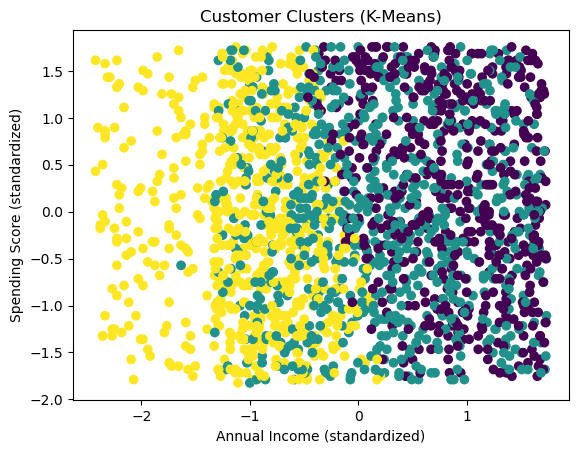

C:\Users\Olenka\AppData\Local\Temp\ipykernel_20200\2557637207.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  wssd_data = pd.concat([wssd_data, current_k], ignore_index=True)


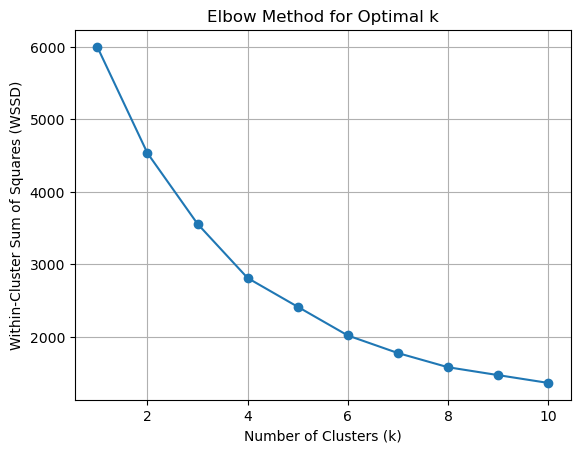


Cluster Summary (Mean values for each group):
           Age  Annual Income ($)  Spending Score (1-100)  Count
Cluster                                                         
0        25.46          149693.71                   57.98    570
1        78.30          121986.78                   49.02    752
2        36.18           65492.87                   47.22    678

💡 The cluster with the highest average spending score is Cluster 0.
This cluster likely represents high-value or premium customers who are key targets for profit growth.


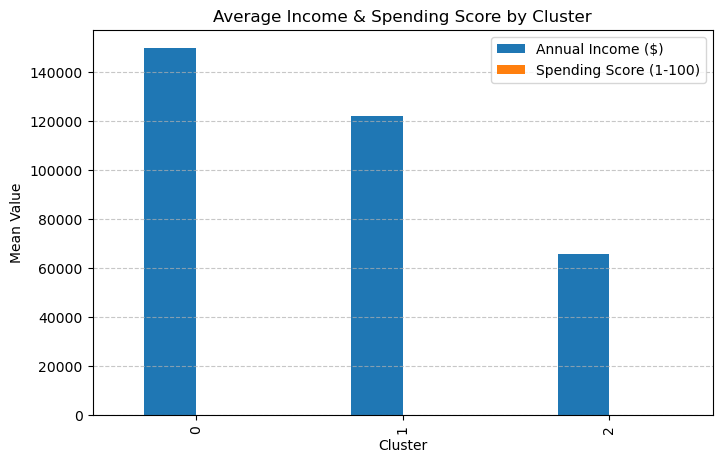

Files saved in ../data/processed/:
 - cluster_assignments.csv
 - cluster_summary.csv


In [15]:
# ---------------------------------------------------------
# CUSTOMER SEGMENTATION - K-MEANS CLUSTERING ANALYSIS + INSIGHTS
# ---------------------------------------------------------

# Step 1: Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Step 2: Load the dataset
from pathlib import Path
df = pd.read_csv("Customers.csv") #relative path

# Step 3: Select features for clustering
features = df[['Age', 'Annual Income ($)', 'Spending Score (1-100)']]

# Step 4: Standardize the data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(features)
standardized_data = pd.DataFrame(standardized_data, columns=features.columns)

# Step 5: Apply K-Means clustering (using k=3 based on Elbow Method)
kmeans = KMeans(n_clusters=3, random_state=0, n_init=10) #avoid version warnings and keep results stable
clusters = kmeans.fit(standardized_data)
standardized_data['Cluster'] = clusters.labels_

# Step 6: Combine cluster labels with original (unscaled) data for interpretation
clustered_customers = df.copy()
clustered_customers['Cluster'] = clusters.labels_

# Step 7: View sample data with clusters
print("Sample of customers with cluster labels:")
print(clustered_customers.head())

# Step 8: Visualize clusters (Income vs Spending)
plt.scatter(
    standardized_data['Annual Income ($)'],
    standardized_data['Spending Score (1-100)'],
    c=standardized_data['Cluster'],
    cmap='viridis'
)
plt.xlabel('Annual Income (standardized)')
plt.ylabel('Spending Score (standardized)')
plt.title('Customer Clusters (K-Means)')
plt.show()

# Step 9: Elbow Method to confirm optimal cluster count
wssd_data = pd.DataFrame(columns=['k', 'wssd'])
for k in range(1, 11):
    kmeans_temp = KMeans(n_clusters=k, random_state=0)
    kmeans_temp.fit(standardized_data[['Age', 'Annual Income ($)', 'Spending Score (1-100)']])
    current_k = pd.DataFrame({'k': [k], 'wssd': [kmeans_temp.inertia_]})
    wssd_data = pd.concat([wssd_data, current_k], ignore_index=True)

plt.plot(wssd_data['k'], wssd_data['wssd'], marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WSSD)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

# Step 10: Cluster Summary Statistics (Business Insights)
cluster_summary = clustered_customers.groupby('Cluster')[['Age', 'Annual Income ($)', 'Spending Score (1-100)']].mean().round(2)
cluster_summary['Count'] = clustered_customers['Cluster'].value_counts().sort_index().values

print("\nCluster Summary (Mean values for each group):")
print(cluster_summary)

# Step 11: Business Interpretation (which cluster is high-value?)
# High-value clusters = high spending score, medium-to-high income
high_value_cluster = cluster_summary['Spending Score (1-100)'].idxmax()

print(f"\n💡 The cluster with the highest average spending score is Cluster {high_value_cluster}.")
print("This cluster likely represents high-value or premium customers who are key targets for profit growth.")

# Step 12: Visual Summary
cluster_summary[['Annual Income ($)', 'Spending Score (1-100)']].plot(kind='bar', figsize=(8,5))
plt.title('Average Income & Spending Score by Cluster')
plt.ylabel('Mean Value')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Step 13: Export cluster assignments and summary for the visualization notebook
from pathlib import Path

PROC = Path("../data/processed")
PROC.mkdir(parents=True, exist_ok=True)

# Export each customer's cluster label
assignments = clustered_customers[["CustomerID", "Cluster"]]
assignments.to_csv(PROC / "cluster_assignments.csv", index=False)

# Export cluster summary for business reporting
cluster_summary.to_csv(PROC / "cluster_summary.csv")

print("Files saved in ../data/processed/:")
print(" - cluster_assignments.csv")
print(" - cluster_summary.csv")
